In [1]:
# 시계열 데이터 연습
# 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 그래프 그려주는거
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv # csv파일 다운로드

--2021-01-23 09:18:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.80, 34.64.4.16
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: `/tmp/sunspots.csv'

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.1s    

2021-01-23 09:18:58 (632 KB/s) - `/tmp/sunspots.csv' saved [70827/70827]



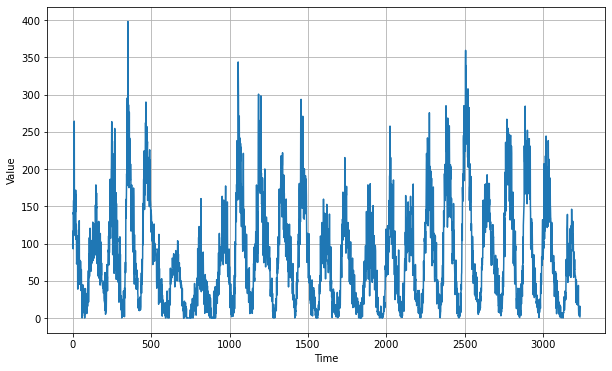

In [11]:
# 받은 csv파일을 리스트 안에 넣기
import csv
# 얘들은 넘파이 배열이 아님. 그냥 파이썬 리스트임
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2])) # Y값(series)
    time_step.append(int(row[0])) # X값(input)

series = np.array(sunspots) 
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [12]:
# 데이터 나누기. 먼저 데이터 그래프로 확인한 다음 적당히 나눠주면 된다. 이것도 모델 성능에 영향을 끼친다. 
# 테스트 데이터는 향후 미래에 대한 예측하는걸 테스트 데이터로 하고 내가 갖고 있는 데이터를 훈련 데이터와 검증 데이터로 나누는 방식을 'roll-forward partitioning'이라고 한다. 

split_time = 3000
# 내가 훈련시킬 때 쓰는 데이터
time_train = time[:split_time]
x_train = series[:split_time]
# 훈련시킨걸 검증할 때 쓰는 데이터
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 # 시계열 데이터는 과거 데이터에 이동 평균을 더해 미래값을 예측하는데 이동 평균을 구할 구간을 window_size로 지정한다. 
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
# 시퀀스(들을) 생성. 생성한 시퀀스를 반환한다.
# 데이터 예측 성능을 높히는 방법은 데이터의 경향성(트렌드), 일정한 패턴, 노이즈를 제거해야한다. 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # 'window_size + 1' 크기의 시퀀스들을 생성. 이게 그 평균 구하는 구간이라고 보면 된다. 
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # 코드 줄을 줄이려고 한 줄에 다넣었다. 데이터베이스를 window_size만큼 나누는걸 시행하고 flat_map에 전달하는 걸 한 줄로 끝내버림
    # flat_map()을 쓰는 이유를 계속해서 찾아봤다. 평평하게 만들고 나면 섞기 쉬워진다고 한다.
    print(ds)
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # 데이터를 x, y로 분류. x를 집어넣으니까 y가 나온다는 걸 보여주기 위함이지
    return ds.batch(batch_size).prefetch(1) # 

In [15]:
def model_forecast(model, series, window_size): # 모델 예측 함수
    # 훈련시킬 때 입력값 양식이랑 똑같이 만들기
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # window_size 단위로 시퀀스 생성
    ds = ds.flat_map(lambda w: w.batch(window_size)) # 평평하게 만들어주기
    ds = ds.batch(32).prefetch(1) # 32 == batch_size. batch_size단위로 데이터 나누기. 나눌 때 묶는 기준은 x, y한개씩
    forecast = model.predict(ds) # 예측
    return forecast # 예측값 반환

In [17]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    # 모델 생성. 합성곱 레이어, 순환 레이어, 완전연결 레이어를 다같이 쓴다. 
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal", # 앞부분을 패딩. 커널 사이즈가 5니까 맨 처음 4개 데이터를 패딩한다(==지운다). 그러면 입력한 데이터의 크기만큼 예측 데이터가 나오게 된다. 
                      # 이걸 그림으로 설명한게 있는데 그걸 봐야 이해가 된다. 
                      activation="relu", # 단순한 활성화 함수. 음수는 무시하고 양수만 받아들이기
                      input_shape=[None, 1]), # 하나의 데이터만 취급하는 시계열 데이터를 받아들이겠다
  tf.keras.layers.LSTM(64, return_sequences=True), # 순환 레이어. return_sequences=True는 출력값으로 나온 모든 데이터를 모두 다음 레이어로 넘기겠다는 뜻.
  tf.keras.layers.LSTM(64, return_sequences=True),
  # 판단용으로 Dense Layer 사용
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400) # 출력값들을 다 400배로 늘려줌
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # 학습률과 손실을 관계를 나타내는 데이터를 생성한다.
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9) # 임의로 데이터 막 뽑은 데이터들로 학습하기. 속도는 빠른데 성능이 떨어진다. 데이터가 많아서 이걸 쓴건가 
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]) 
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<FlatMapDataset shapes: (None, 1), types: tf.float64>
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 103ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 1s 85ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 1s 99ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 1s 90ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 1s 90ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 1s 93ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 1s 103ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 1s 101ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 1s 103ms/ste

(1e-08, 0.0001, 0.0, 60.0)

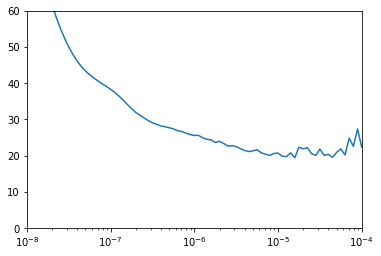

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"]) # 학습률과 손실 사이의 관계를 그래프로 표시
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
tf.keras.backend.clear_session() # 모델 새로 생성하기 전 이전 학습 기록 다 제거. 메모리 많이 차지하는거 막기 위함

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size) # 데이터도 새로 생성
# 앞서 만들었던것과 똑같은 모델 생성
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) # 앞서 본 학습률, 손실 그래프를 보고 새로 설정한 학습률을 사용
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500) # 반영해서 훈련시킨거니까 에포크를 늘려서 훈련시킨다.(각잡고 훈련)

Epoch 301/500
30/30 [==============================] - 4s 137ms/step - loss: 15.4203 - mae: 15.9081
Epoch 302/500
30/30 [==============================] - 4s 134ms/step - loss: 15.1950 - mae: 15.6830
Epoch 303/500
30/30 [==============================] - 4s 136ms/step - loss: 14.6588 - mae: 15.1430
Epoch 304/500
30/30 [==============================] - 4s 139ms/step - loss: 14.5611 - mae: 15.0455
Epoch 305/500
30/30 [==============================] - 5s 151ms/step - loss: 14.6945 - mae: 15.1789
Epoch 306/500
30/30 [==============================] - 5s 146ms/step - loss: 14.6925 - mae: 15.1774
Epoch 307/500
30/30 [==============================] - 5s 141ms/step - loss: 14.7259 - mae: 15.2111
Epoch 308/500
30/30 [==============================] - 5s 152ms/step - loss: 14.7315 - mae: 15.2158
Epoch 309/500
30/30 [==============================] - 5s 171ms/step - loss: 14.7353 - mae: 15.2204
Epoch 310/500
30/30 [==============================] - 6s 176ms/step - loss: 14.6589 - mae: 15.1426


In [20]:
# 예측
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size) # 모델, 데이터, 시퀀스 사이즈 넣고 예측 돌리기
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0] # 예측한 것 중 뒷 부분(검증셋)만 가져오기(검증셋 부분만 예측한 뒤 실제 검증셋과 비교)

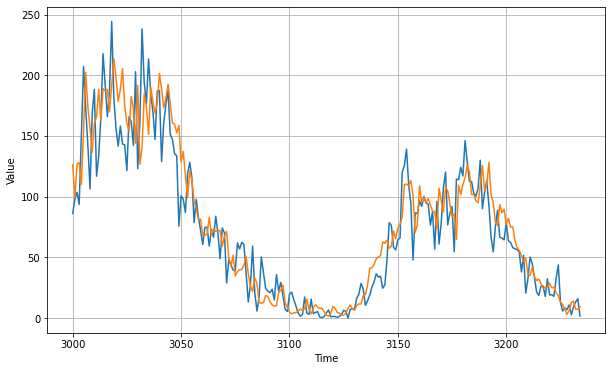

In [21]:
# 그래프 비교
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # MAE 계산. 높게 나온다. 이걸 줄일 방법을 생각해보자. 

16.588446